### Loading libraries

In [3]:
import os
import time
from joblib import dump, load
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances

### Loading and preprocessing data

In [4]:
# file paths for saving/loading 
lsa_matrix_file = 'lsa_matrix.joblib'
product_data_file = '../newData/flipkart_cleaned.csv'
purchase_history_file = '../newData/synthetic_v2.csv'

### content based rec sys aims to recommend items based on similarity between items
df_products = pd.read_csv(product_data_file)
# renaming columns
df_products.rename(columns={'uniq_id': 'Product ID'}, inplace=True)

df_purchase = pd.read_csv(purchase_history_file)

# merge df_purchase with df_products on Product ID
df = pd.merge(df_purchase, df_products, left_on='Product ID', right_on='Product ID')

# creating content column
df['content'] = (df['product_name'].astype(str) + ' ' + df['product_category_tree'].astype(str) + ' ' + df['retail_price'].astype(str) + ' ' + df['discounted_price'].astype(str) + ' ' + df['discount'].astype(str) + ' ' + df['description'].astype(str) + ' ' + df['overall_rating'].astype(str) + ' ' + df['brand'].astype(str) + ' ' + df['product_specifications'].astype(str))
df['content'] = df['content'].fillna('')

df_products['content'] = (df['product_name'].astype(str) + ' ' + df['product_category_tree'].astype(str) + ' ' + df['retail_price'].astype(str) + ' ' + df['discounted_price'].astype(str) + ' ' + df['discount'].astype(str) + ' ' + df['description'].astype(str) + ' ' + df['overall_rating'].astype(str) + ' ' + df['brand'].astype(str) + ' ' + df['product_specifications'].astype(str))
df['content'] = df['content'].fillna('')

# print(df.head())
print(df.info())
# print(df_products.isna().sum())
# print(df_purchase.isna().sum())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124956 entries, 0 to 124955
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Order ID                     124956 non-null  object 
 1   Product ID                   124956 non-null  object 
 2   Product Quantity             124956 non-null  int64  
 3   Product Price Each           124956 non-null  float64
 4   Order Total                  124956 non-null  float64
 5   Order Date                   124956 non-null  object 
 6   Purchase Address             124956 non-null  object 
 7   User rating for the product  124956 non-null  float64
 8   User ID                      124956 non-null  object 
 9   User Age                     124956 non-null  int64  
 10  User Occupation              124956 non-null  object 
 11  User Income                  124956 non-null  int64  
 12  User Interests               124956 non-null  object 
 13 

In [11]:
print('product info shape', df_products.shape)
print('purchase info shape', df_purchase.shape)

product info shape (19906, 13)
purchase info shape (124968, 14)


In [6]:
# getting user input
# user_product = input("Enter a product: ")

 # Start timer after user input
start_time = time.time()

 # Call the recommendation system function
# recommendations = get_recommendations(user_product, 10)

# Print recommendations
# for rec in recommendations:
#     print(rec)

# End timer for the entire program
# end_time = time.time()
# print("Time taken to find recommendations: {:.2f} seconds".format(end_time - # start_time))


In [115]:
product_data_file = '../newData/flipkart_cleaned.csv'
orders_data_file = '../newData/synthetic_v2.csv'
df_orders = pd.read_csv(orders_data_file)

lsa_matrix_file = 'lsa_matrix.joblib'
lsa_matrix = load(lsa_matrix_file)
# print(lsa_matrix)


In [59]:
# Function to load and preprocess the data
def load_product_data(product_data_file):
    df = pd.read_csv(product_data_file)
    df['content'] = (df['product_name'].astype(str) + ' ' + df['product_category_tree'].astype(str) + ' ' + df['retail_price'].astype(str) + ' ' + df['discounted_price'].astype(str) + ' ' + df['discount'].astype(str) + ' ' + df['description'].astype(str) + ' ' +
    df['overall_rating'].astype(str) + ' ' + df['brand'].astype(str) + ' ' + df['product_specifications'].astype(str))
    df['content'] = df['content'].fillna('')

    print("successfully loaded df")
    return df

In [75]:
df = load_product_data(product_data_file)
df.shape

successfully loaded df


(19906, 13)

# Different Matrix

### Bag of Words

In [5]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(df_products['content'])
# bow
bow_df = pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names_out())
bow_df

,00,000,00000000,0000000000000,00001,000014,0000300046,0000300050,00012,00013,...,zuiko,zunia,zuri,zw,zwart,zyxel,zzxe1021boxprint,½continue,ãƒâ,žã
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19904,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
bow.shape

(19906, 28840)

### TFIDF

In [6]:
tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(bow)

tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df

,00,000,00000000,0000000000000,00001,000014,0000300046,0000300050,00012,00013,...,zuiko,zunia,zuri,zw,zwart,zyxel,zzxe1021boxprint,½continue,ãƒâ,žã
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
tfidf.shape

(19906, 28840)

In [12]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_products['content'])
tfidf_matrix.shape
# cosine_sim_tfidf = cosine_similarity(tfidf_matrix, tfidf_matrix)
# cosine_sim_tfidf

(19906, 28572)

### LSA

In [7]:
n_components = 100

lsa = TruncatedSVD(n_components=n_components)
# lsa.fit(tfidf)
# lsa_matrix = lsa.transform(tfidf)
lsa_matrix = lsa.fit_transform(tfidf)
lsa_df = pd.DataFrame(lsa_matrix, columns=[f'Topic {i+1}' for i in range(n_components)])
lsa_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99,Topic 100
0,0.124782,0.030464,0.034604,-0.006508,-0.029016,0.064866,-0.069061,0.006342,0.012149,-0.068241,...,0.031103,-0.016362,-0.027531,-0.012520,0.073205,-0.004275,0.007320,-0.008422,-0.021018,0.017259
1,0.110745,0.093125,0.074101,-0.002630,-0.046674,0.177530,-0.129160,-0.011214,0.090787,-0.319556,...,0.005542,-0.006535,0.006384,0.013152,0.019034,0.057024,0.045167,0.008301,0.000858,-0.020583
2,0.367322,-0.191123,-0.072088,-0.064854,-0.003966,-0.027259,0.037362,0.105650,-0.031734,0.000240,...,0.028699,0.010338,-0.009536,0.031302,-0.025316,-0.016787,0.013322,-0.009545,-0.007275,-0.000166
3,0.407849,-0.255727,-0.100454,-0.244614,-0.026207,-0.024167,0.112651,-0.165835,0.137285,0.041476,...,-0.013531,0.004672,-0.020390,0.005826,0.013431,-0.049554,-0.038714,-0.011918,0.023164,0.020737
4,0.199377,-0.045241,0.009731,0.025174,0.011841,-0.000417,-0.030731,0.036098,-0.103100,-0.027655,...,0.074341,0.003758,-0.000283,0.002209,-0.029507,0.042031,0.017189,-0.037266,0.040521,0.015651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19901,0.166217,0.280219,-0.085788,-0.044840,0.134561,0.000704,0.004021,-0.001011,0.010979,-0.056102,...,-0.015442,0.040837,0.047612,-0.019253,0.030350,0.021387,-0.039699,-0.021196,0.001822,0.018643
19902,0.159252,0.216022,-0.049926,0.002426,-0.064893,0.017337,-0.040616,0.001333,0.021454,-0.113908,...,0.027202,-0.006509,0.002614,-0.019385,0.002727,0.011240,-0.010947,-0.016500,0.022138,0.003097
19903,0.188142,0.120259,0.810474,-0.078080,0.035487,-0.271576,0.275582,0.155423,0.077829,0.043505,...,0.004659,0.003448,-0.001893,-0.002770,-0.000418,-0.003002,-0.000748,0.001615,-0.000091,0.000158
19904,0.240975,0.443970,-0.141957,-0.007066,-0.179596,-0.135047,0.087017,-0.035622,-0.028399,0.027232,...,0.004764,0.047757,-0.013764,0.025537,0.030126,-0.001721,0.018349,0.039410,-0.068247,0.004963


# Getting Similarity Score Matrix

### Cosine Similarity: focuses on direcion of vectors, effective when magnitude not important
### Euclidean Distance: gives a sense of absolute dissimilarity in terms of distance between vectors, but sensitive to magnitude
### Pearson Correlation: good for measuring linear relationships, but doen't work well with vectors where patterns matter more than absolute values

### Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming you have your matrices: bow_matrix, tfidf_matrix, lsa_matrix
matrix_dict = {
    'BoW': bow_matrix,
    'TF-IDF': tfidf_matrix,
    'LSA': lsa_matrix
}

cosine_sim_dict = {}

# Loop through the matrices and compute cosine similarity
for name, matrix in matrix_dict.items():
    cosine_sim_dict[name] = cosine_similarity(matrix)
    print(f"Cosine Similarity Matrix for {name}: {cosine_sim_dict[name].shape}")
    # Example: print first row of the cosine similarity matrix for each
    print(f"{name} Cosine Similarity (First Row):", cosine_sim_dict[name][0])

# Now cosine_sim_dict contains the cosine similarity matrices for BoW, TF-IDF, and LSA


In [12]:
# 1. Cosine Similarity for BoW matrix
cosine_sim_bow = cosine_similarity(bow)
print(f"Cosine Similarity Matrix for BoW: {cosine_sim_bow.shape}")
print("BoW Cosine Similarity (First Row):", cosine_sim_bow[0])

Cosine Similarity Matrix for BoW: (19906, 19906)
BoW Cosine Similarity (First Row): [1.         0.23907098 0.16106236 ... 0.12830828 0.16635641 0.15916967]


In [13]:
# 2. Cosine Similarity for TF-IDF matrix
cosine_sim_tfidf = cosine_similarity(tfidf)
print(f"Cosine Similarity Matrix for TF-IDF: {cosine_sim_tfidf.shape}")
print("TF-IDF Cosine Similarity (First Row):", cosine_sim_tfidf[0])

Cosine Similarity Matrix for TF-IDF: (19906, 19906)
TF-IDF Cosine Similarity (First Row): [1.         0.05359093 0.01683845 ... 0.02942154 0.02558636 0.01764577]


In [15]:
# 3. Cosine Similarity for LSA matrix
cosine_sim_lsa = cosine_similarity(lsa_matrix)
print(f"Cosine Similarity Matrix for LSA: {cosine_sim_lsa.shape}")
print("LSA Cosine Similarity (First Row):", cosine_sim_lsa[0])

Cosine Similarity Matrix for LSA: (19906, 19906)
LSA Cosine Similarity (First Row): [1.         0.17952568 0.09375772 ... 0.07873361 0.0898451  0.09553305]


In [58]:
# Cosine similarity
cosine_sim = cosine_similarity(lsa_matrix)
print(cosine_sim)
cosine_sim.shape

[[1.         0.18312674 0.09099922 ... 0.08008375 0.08872537 0.09362903]
 [0.18312674 1.         0.03889196 ... 0.06253612 0.03509854 0.04549488]
 [0.09099922 0.03889196 1.         ... 0.01644872 0.04664032 0.87986047]
 ...
 [0.08008375 0.06253612 0.01644872 ... 1.         0.02754563 0.01640811]
 [0.08872537 0.03509854 0.04664032 ... 0.02754563 1.         0.03738823]
 [0.09362903 0.04549488 0.87986047 ... 0.01640811 0.03738823 1.        ]]


(19906, 19906)

### Euclidean Distances

In [17]:
# 1. Euclidean Distance for BoW matrix
euclidean_bow = euclidean_distances(bow)
print(f"Euclidean Distance Matrix for BoW: {euclidean_bow.shape}")
print("BoW Euclidean Distance (First Row):", euclidean_bow[0])

Euclidean Distance Matrix for BoW: (19906, 19906)
BoW Euclidean Distance (First Row): [ 0.         18.62793601 17.74823935 ... 22.82542442 19.74841766
 17.88854382]


In [18]:
# 2. Euclidean Distance for TF-IDF matrix
euclidean_tfidf = euclidean_distances(tfidf)
print(f"Euclidean Distance Matrix for tfidf: {euclidean_tfidf.shape}")
print("TFIDF Euclidean Distance (First Row):", euclidean_tfidf[0])

Euclidean Distance Matrix for tfidf: (19906, 19906)
TFIDF Euclidean Distance (First Row): [0.         1.37579728 1.40225643 ... 1.39325407 1.39600404 1.40168058]


In [19]:
# 3. Euclidean Distance for LSA matrix
euclidean_lsa = euclidean_distances(lsa_matrix)
print(f"Euclidean Distance Matrix for LSA: {euclidean_lsa.shape}")
print("LSA Euclidean Distance (First Row):", euclidean_lsa[0])

Euclidean Distance Matrix for LSA: (19906, 19906)
LSA Euclidean Distance (First Row): [0.         0.77980876 0.63209398 ... 1.03196164 0.83390868 0.66935352]


### Pearson Correlation

In [10]:
# 1. Pearson Correlation for BoW matrix
bow_dense = bow.toarray()
pearson_bow = np.corrcoef(bow_dense)
# print(f"Pearson Correlation Matrix for BoW: {pearson_bow.shape}")
# print("BoW Pearson Correlation (First Row):", pearson_bow[0])
pearson_bow

array([[1.        , 0.23785454, 0.15975483, ..., 0.12676296, 0.16489516,
        0.15786036],
       [0.23785454, 1.        , 0.08475488, ..., 0.07051576, 0.13245224,
        0.09996317],
       [0.15975483, 0.08475488, 1.        , ..., 0.07928224, 0.13089157,
        0.71360476],
       ...,
       [0.12676296, 0.07051576, 0.07928224, ..., 1.        , 0.0913556 ,
        0.0783335 ],
       [0.16489516, 0.13245224, 0.13089157, ..., 0.0913556 , 1.        ,
        0.12933649],
       [0.15786036, 0.09996317, 0.71360476, ..., 0.0783335 , 0.12933649,
        1.        ]])

In [9]:
# 2. Pearson Correlation for tfidf Matrix
tfidf_dense = tfidf.toarray()
pearson_tfidf = np.corrcoef(tfidf_dense)
print(f"Pearson Correlation Matrix for TFIDF: {pearson_tfidf.shape}")
print("TFIDF Pearson Correlation (First Row):", pearson_tfidf[0])

Pearson Correlation Matrix for TFIDF: (19906, 19906)
TFIDF Pearson Correlation (First Row): [1.         0.05266792 0.01596867 ... 0.02818159 0.02456373 0.01674347]


In [23]:
# 3. Pearson Correlation for LSA Matrix
pearson_lsa = np.corrcoef(lsa_matrix)
print(f"Pearson Correlation Matrix for LSA: {pearson_lsa.shape}")
print("LSA Pearson Correlation (First Row):", pearson_lsa[0])

Pearson Correlation Matrix for LSA: (19906, 19906)
LSA Pearson Correlation (First Row): [1.         0.16990358 0.11681998 ... 0.06537079 0.07587507 0.10026702]


### Getting LSA Matrix
- if LSA matrix already existed, no need to recalculate
- to calculate LSA
    1. CountVectorizer: convert text data into a bag-of-words model (each cell in matrix contains count of unique words in that document)
    2. TF-IDF: adjust raw word counts, considering how important a word is, relative to all other documents
    3. LSA: using TruncatedSVD which performs dimensionaity reduction using SVD.
        - LSA applied as tf-idf matrix reduced to smaller matrix = capturing most important patterns

In [3]:
def get_lsa_matrix(df, lsa_matrix_file):
    recalculate_lsa = False
    if os.path.exists(lsa_matrix_file):
        lsa_matrix_mtime = os.path.getmtime(lsa_matrix_file)
        product_data_mtime = os.path.getmtime(product_data_file)
        if product_data_mtime > lsa_matrix_mtime:
            print("product databased changed... recalculating lsa matrix")
            recalculate_lsa = True
    else:
        print("no lsa matrix found... calculating lsa matrix")
        recalculate_lsa = True

    if recalculate_lsa:
        print("commencing calculating lsa")
        vectorizer = CountVectorizer()
        bow = vectorizer.fit_transform(df['content'])

        tfidf_transformer = TfidfTransformer()
        tfidf = tfidf_transformer.fit_transform(bow)
        
        lsa = TruncatedSVD(n_components=100, algorithm='arpack')
        lsa.fit(tfidf)
        lsa_matrix = lsa.transform(tfidf)
        dump(lsa_matrix, lsa_matrix_file)
    else:
        print("lsa matrix found... loading...")
        lsa_matrix = load(lsa_matrix_file)
    print(lsa_matrix)
    return lsa_matrix

## Get recommendations


In [43]:
def content_based_recommend(user_id, purchase_history_df, product_info_df, cosine_sim, top_n=10):
    # retrieve user's purchases
    user_purchases = purchase_history_df[purchase_history_df['User ID'] == user_id]
    rated_products = user_purchases['Product ID'].values
    # print("rated products:", rated_products)

    # store predicted ratings for products not yet rated by the user
    user_predicted_ratings = {}

    # Limit to the first 1000 rows of product_info_df
    for idx, row in product_info_df.iloc[:100].iterrows():
        product_id = row['Product ID']
        # print('product id', product_id)
        # if product is not rated
        if product_id not in rated_products:
            # find index of the product in df
            product_index = product_info_df.index[product_info_df['Product ID'] == product_id].tolist()[0]
            # get similarity scores for the current product
            similar_products = cosine_sim[product_index]
            # print("similarity scores", similar_products)

            # get indices of rated products
            rated_product_indices = product_info_df[product_info_df['Product ID'].isin(rated_products)].index

            # get similarity scores using indices
            similarity_scores = similar_products[rated_product_indices]

            # get user ratings for items purchase
            user_ratings = user_purchases[user_purchases['Product ID'].isin(df['Product ID'])]['User rating for the product'].values

            # check for non-zero sum
            if np.sum(similarity_scores) != 0:

                # calculate predicted ratings based on similarity scores
                predicted_rating = np.dot(similarity_scores, user_ratings) / np.sum(similarity_scores)
                # print(f"Predicted rating for Product ID {product_id}: {predicted_rating:.2f}")
                user_predicted_ratings[product_id] = predicted_rating

    # sort the predictions and return top_n recommendations
    recommended_products = sorted(user_predicted_ratings.items(), key=lambda x: x[1], reverse=True)[:top_n]
    # recommended_products = sorted(list(enumerate(similar_products)), key=lambda x: x[1], reverse=True)[:top_n]


    # print("recommended", recommended_products)
    '''
    recommendations = []
    for i, score in recommended_products:
        # recommendations.append(df.loc[i, 'product_name'])
        product_name = product_info_df.loc[i, 'product_name']
        retail_price = product_info_df.loc[i, 'retail_price']
        overall_rating = product_info_df.loc[i, 'overall_rating']
        recommendations.append({
            'product_name': product_name,
            'retail_price': retail_price,
            'overall_rating': overall_rating,
            'similarity_score': score
        })
    '''

    recommendations = []
    for product_id, predicted_rating in recommended_products:
        # Access product details by matching the Product ID
        product_details = product_info_df[product_info_df['Product ID'] == product_id].iloc[0]
        product_name = product_details['product_name']
        retail_price = product_details['retail_price']
        overall_rating = product_details['overall_rating']

        recommendations.append({
            'product_name': product_name,
            'retail_price': retail_price,
            'overall_rating': overall_rating,
            'predicted_rating': predicted_rating
        })
    
    return recommendations

In [44]:
content_based_recommend("U06610", df_purchase, df_products, cosine_sim_lsa)

[{'product_name': 'fabhomedecor fabric double sofa bed',
  'retail_price': 32157.0,
  'overall_rating': 'no rating available',
  'predicted_rating': 3.738574382550025},
 {'product_name': 'swagga women clogs',
  'retail_price': 1500.0,
  'overall_rating': 'no rating available',
  'predicted_rating': 3.5420908441849015},
 {'product_name': "dongli printed boy's round neck t-shirt",
  'retail_price': 2400.0,
  'overall_rating': 'no rating available',
  'predicted_rating': 3.4504529547138647},
 {'product_name': "masara solid women's straight kurta",
  'retail_price': 999.0,
  'overall_rating': 'no rating available',
  'predicted_rating': 3.4135816140439963},
 {'product_name': "reckler slim fit men's jeans",
  'retail_price': 5398.0,
  'overall_rating': 'no rating available',
  'predicted_rating': 3.3804154828144104},
 {'product_name': "pick pocket embroidered women's waistcoat",
  'retail_price': 899.0,
  'overall_rating': 'no rating available',
  'predicted_rating': 3.3397704840739637},
 {

In [61]:
def get_recommendations(user_product, product_info_df, similarity_matrix, top_n=10):
    match = process.extractOne(user_product, df['product_name'])
    closest_match = match[0]
    score = match[1]
    print("closest match and score: ", closest_match, score)

    if score < 30:
       return "No close match found"
    
    product_index = df[df['product_name'] == closest_match].index[0]
    print("product: ", product_index)

    # similarity_scores = cosine_similarity(lsa_matrix[product_index].reshape(1, -1), lsa_matrix)
    # similarity_scores = cosine_similarity(matrix[user_product].reshape(1, -1), matrix)
    # get similarity scores for the current product
    # product_id = product_info_df['Product ID']
    # product_index = product_info_df.index[product_info_df['Product ID'] == product_id].tolist()[0]
    similar_products = similarity_matrix[product_index]
    # print("similarity scores", similarity_scores)
    # print("similarity scores", similarity_scores.shape)
    # print("similarity scores [0]: ", similarity_scores[0])
    # print("similarity scores [0] shape: ", sorted(list(enumerate(similarity_scores[0])), key=lambda x: x[1], reverse=True)[1:10])

    # similar_products = list(enumerate(similarity_scores[0]))
    # print("similar_products: ", similar_products)

    # sorted_similar_products = sorted(similar_products, key=lambda x: x[1], reverse=True)[1:top_n+1]
    sorted_similar_products = sorted(list(enumerate(similar_products)), key=lambda x: x[1], reverse=True)[0:top_n+1]


    # print("sorted_similar_products", sorted_similar_products)

    recommendations = []
    for i, score in sorted_similar_products:
        # recommendations.append(df.loc[i, 'product_name'])
        product_id = product_info_df.loc[i, 'Product ID']
        product_name = product_info_df.loc[i, 'product_name']
        retail_price = product_info_df.loc[i, 'retail_price']
        overall_rating = product_info_df.loc[i, 'overall_rating']
        recommendations.append({
            'product ID': product_id,
            'product_name': product_name,
            'retail_price': retail_price,
            'overall_rating': overall_rating,
            'similarity_score': score
        })
    
    print(recommendations)
    return recommendations

In [81]:
print(df.shape)

(19906, 13)


In [40]:
user_product = 'socks'
recommendations = get_recommendations(user_product, df_products, lsa_matrix)

closest match and score:  mayor men's crew length socks 90
product:  1880
[{'product_name': 'colat colat_mw20 sheen analog watch  - for men, women, boys, girls', 'retail_price': 3999.0, 'overall_rating': '5', 'similarity_score': 0.15607426966873633}, {'product_name': 'steppings trendy boots', 'retail_price': 1799.0, 'overall_rating': 'no rating available', 'similarity_score': 0.0939025387492947}, {'product_name': "alisha solid women's cycling shorts", 'retail_price': 999.0, 'overall_rating': 'no rating available', 'similarity_score': 0.08756631747753714}, {'product_name': "carrel printed women's", 'retail_price': 2499.0, 'overall_rating': 'no rating available', 'similarity_score': 0.0725034857424133}, {'product_name': 'casedeal microsoft nokia lumia x2 back panel', 'retail_price': 1999.0, 'overall_rating': 'no rating available', 'similarity_score': 0.07184290719514472}, {'product_name': "silver streak men's printed casual denim shirt", 'retail_price': 1299.0, 'overall_rating': 'no rati

### Evaluation: Precision and Recall

##### Exploratory data analysis
- looking at the number of distribution of ratings for each user, and distribution of user ratings

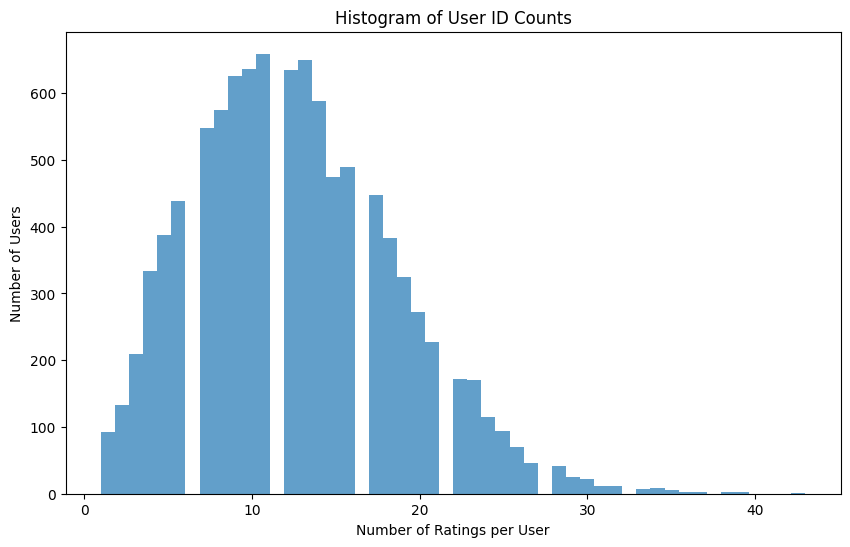

In [123]:
# Distribution of Number of Ratings a user has given
user_counts = df_orders['User ID'].value_counts()

plt.figure(figsize=(10, 6))
plt.hist(user_counts, bins=50, alpha=0.7)
plt.title('Histogram of User ID Counts')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.show()

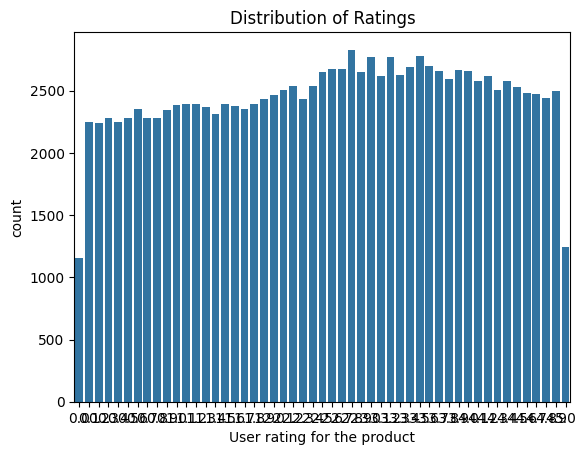

In [125]:
# Distribution of Ratings
sns.countplot(x='User rating for the product', data = df_orders)
plt.title('Distribution of Ratings')
plt.show()

### Creation of user_info dataframe
- user id
- total products ordered
- median rating of products
- liked products (rating >= median)
- disliked products (rating < median)

In [48]:
# Ensure 'Order Date' is in datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Step 1: Calculate the median rating for each user
user_median_rating = df.groupby('User ID')['User rating for the product'].median().reset_index()
user_median_rating.columns = ['User ID', 'Median User Rating']
user_median_rating


,User ID,Median User Rating
0,U00001,3.00
1,U00002,1.20
2,U00003,1.70
3,U00004,3.40
4,U00005,2.40
...,...,...
9935,U09996,2.90
9936,U09997,3.90
9937,U09998,2.20
9938,U09999,2.55


In [49]:
# Step 2: Calculate the total number of products ordered by each user
user_total_products = df.groupby('User ID')['Product ID'].count().reset_index()
user_total_products.columns = ['User ID', 'Total Products Ordered']
user_total_products

,User ID,Total Products Ordered
0,U00001,19
1,U00002,13
2,U00003,11
3,U00004,9
4,U00005,17
...,...,...
9935,U09996,25
9936,U09997,13
9937,U09998,3
9938,U09999,34


In [50]:
# Step 3: Merge the median rating and total products data
user_info = pd.merge(user_median_rating, user_total_products, on='User ID')
user_info

,User ID,Median User Rating,Total Products Ordered
0,U00001,3.00,19
1,U00002,1.20,13
2,U00003,1.70,11
3,U00004,3.40,9
4,U00005,2.40,17
...,...,...,...
9935,U09996,2.90,25
9936,U09997,3.90,13
9937,U09998,2.20,3
9938,U09999,2.55,34


In [62]:
# Step 4: Define liked and disliked products, including first liked/disliked products based on order date
def liked_disliked_products(user_id, df, user_info):
    median_rating = user_info[user_info['User ID'] == user_id]['Median User Rating'].values[0]
    
    # Filter the user's purchases and sort by 'Order Date'
    user_data = df[df['User ID'] == user_id].sort_values('Order Date')
    
    # Liked products: User rating >= median rating
    liked = user_data[user_data['User rating for the product'] >= median_rating]
    liked_products = liked['Product ID'].tolist()
    
    # Disliked products: User rating < median rating
    disliked = user_data[user_data['User rating for the product'] < median_rating]
    disliked_products = disliked['Product ID'].tolist()
    
    # First liked product based on the earliest order date
    first_liked = liked.iloc[0]['Product ID'] if not liked.empty else None
    
    # First disliked product based on the earliest order date
    first_disliked = disliked.iloc[0]['Product ID'] if not disliked.empty else None
    
    return liked_products, disliked_products, first_liked, first_disliked


In [52]:
# Step 5: Apply the function to get liked/disliked products and first occurrences for each user
user_info['Liked Products'] = user_info['User ID'].apply(lambda x: liked_disliked_products(x, df, user_info)[0])
user_info['Disliked Products'] = user_info['User ID'].apply(lambda x: liked_disliked_products(x, df, user_info)[1])
user_info['First Liked Product'] = user_info['User ID'].apply(lambda x: liked_disliked_products(x, df, user_info)[2])
user_info['First Disliked Product'] = user_info['User ID'].apply(lambda x: liked_disliked_products(x, df, user_info)[3])

In [53]:
user_info.head()

,User ID,Median User Rating,Total Products Ordered,Liked Products,Disliked Products,First Liked Product,First Disliked Product
0,U00001,3.0,19,"[6bda41aff283f501106b21fbea1b06ff, 66b87bb4b76...","[aff53642926f2273cb201266eb4a12e7, a903aaf8265...",6bda41aff283f501106b21fbea1b06ff,aff53642926f2273cb201266eb4a12e7
1,U00002,1.2,13,"[d650f51fbc6dbd3f0ee4767f68e2c1c5, 50f63e8f305...","[f2cd1a41adebbfba0cdb822b74a9e525, 16655211772...",d650f51fbc6dbd3f0ee4767f68e2c1c5,f2cd1a41adebbfba0cdb822b74a9e525
2,U00003,1.7,11,"[3a4fad4600f2db2f77a00774b26c8d11, 500e74763e5...","[89107413457743486e152eb4ad29cd05, 5442a98c3d5...",3a4fad4600f2db2f77a00774b26c8d11,89107413457743486e152eb4ad29cd05
3,U00004,3.4,9,"[68c7e19211206ab2b54e534c2123066c, aab3a632a14...","[a4dab13bb15b7bda15c08a183f543f09, c4ccaf522cb...",68c7e19211206ab2b54e534c2123066c,a4dab13bb15b7bda15c08a183f543f09
4,U00005,2.4,17,"[10e85a4c93fc338d552cea5982ccac90, 16c18ce0aff...","[97a9caec34fa70d1a8c7fa24a916159b, 0f48048752b...",10e85a4c93fc338d552cea5982ccac90,97a9caec34fa70d1a8c7fa24a916159b


### Recall and Precision

### function to generate liked and disliked products

In [63]:
# Function to get recommendations based on first liked and disliked products
def get_user_recommendations(user_id, user_info_df, product_info_df, similarity_matrix):
    # Step 1: Retrieve the user's first liked and disliked products
    first_liked_product = user_info_df[user_info_df['User ID'] == user_id]['First Liked Product'].values[0]
    first_disliked_product = user_info_df[user_info_df['User ID'] == user_id]['First Disliked Product'].values[0]
    
    # Get the number of liked and disliked products for the user
    num_liked = len(user_info_df[user_info_df['User ID'] == user_id]['Liked Products'].values[0])
    num_disliked = len(user_info_df[user_info_df['User ID'] == user_id]['Disliked Products'].values[0])

    # Step 2: Generate recommendations for liked products
    recommended_liked_products = get_recommendations(first_liked_product, product_info_df, similarity_matrix, top_n=num_liked)

    # Step 3: Generate recommendations for disliked products
    recommended_disliked_products = get_recommendations(first_disliked_product, product_info_df, similarity_matrix, top_n=num_disliked)

    # Step 4: Return the recommendations in two separate lists
    return recommended_liked_products, recommended_disliked_products

In [68]:
recommended_liked_products, recommended_disliked_products= get_user_recommendations("U06610", user_info, df_products, cosine_sim_lsa)

closest match and score:  netgear d1500 34
product:  1988
[{'product ID': 'dc0827db6807dcc784b7fdbd3f9d13c6', 'product_name': "s4s comfortable women's full coverage bra", 'retail_price': 799.0, 'overall_rating': 'no rating available', 'similarity_score': 1.0}, {'product ID': '20cf08ae845d5fd8f2b8cf52b3b9d840', 'product_name': 'kennel rubber dumbell with bell - small rubber rubber toy for dog', 'retail_price': 190.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9780871269967059}, {'product ID': 'd01403ca5884c3c054a8b7a6067a35c7', 'product_name': "numero uno striped men's polo t-shirt", 'retail_price': 1399.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9780871269967059}, {'product ID': 'a508ae8d82abfbb3e4054164bb87b2c7', 'product_name': "glus liftu women's push-up bra", 'retail_price': 950.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9705822591489079}, {'product ID': 'b91b13aceec0a140944a2c8915e45e59', 'product_name': 'bhalaria d

### Creating a confusion matrix
- TP: recommended as liked and actually liked
- TN: recommended as disliked and actually disliked
- FP: recommended as liked but actially disliked
- FN: recommended as disliked but actually liked

In [69]:
print("Recommended Liked Products:")
print(recommended_liked_products)
print("Recommended Disliked Products:")
print(recommended_disliked_products)


Recommended Liked Products:
[{'product ID': 'dc0827db6807dcc784b7fdbd3f9d13c6', 'product_name': "s4s comfortable women's full coverage bra", 'retail_price': 799.0, 'overall_rating': 'no rating available', 'similarity_score': 1.0}, {'product ID': '20cf08ae845d5fd8f2b8cf52b3b9d840', 'product_name': 'kennel rubber dumbell with bell - small rubber rubber toy for dog', 'retail_price': 190.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9780871269967059}, {'product ID': 'd01403ca5884c3c054a8b7a6067a35c7', 'product_name': "numero uno striped men's polo t-shirt", 'retail_price': 1399.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9780871269967059}, {'product ID': 'a508ae8d82abfbb3e4054164bb87b2c7', 'product_name': "glus liftu women's push-up bra", 'retail_price': 950.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9705822591489079}, {'product ID': 'b91b13aceec0a140944a2c8915e45e59', 'product_name': 'bhalaria dessert fork stainless steel de

In [70]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(user_id, user_info_df, product_info_df, similarity_matrix):
    # Step 1: Retrieve the user's liked and disliked products
    actual_liked_products = user_info_df[user_info_df['User ID'] == user_id]['Liked Products'].values[0]
    actual_disliked_products = user_info_df[user_info_df['User ID'] == user_id]['Disliked Products'].values[0]

    # Step 2: Generate recommendations
    recommended_liked_products, recommended_disliked_products = get_user_recommendations(user_id, user_info_df, product_info_df, similarity_matrix)

    # Step 3: Extract only Product IDs from the recommendations
    recommended_liked_product_ids = {product['product ID'] for product in recommended_liked_products}
    recommended_disliked_product_ids = {product['product ID'] for product in recommended_disliked_products}

    # Step 4: Create sets for easier comparison
    actual_liked_set = set(actual_liked_products)
    actual_disliked_set = set(actual_disliked_products)

    # Step 5: Initialize counts for TP, TN, FP, FN
    TP = len(recommended_liked_product_ids & actual_liked_set)  # Recommended liked, actually liked
    TN = len(recommended_disliked_product_ids & actual_disliked_set)  # Recommended disliked, actually disliked
    FP = len(recommended_liked_product_ids & actual_disliked_set)  # Recommended liked, actually disliked
    FN = len(recommended_disliked_product_ids & actual_liked_set)  # Recommended disliked, actually liked

    # Step 6: Create confusion matrix
    confusion = [[TP, FP], [FN, TN]]

    return confusion

# Example usage
user_id = 'U06610'
conf_matrix = create_confusion_matrix(user_id, user_info, df_products, cosine_sim_lsa)
print("Confusion Matrix:")
print(conf_matrix)

closest match and score:  netgear d1500 34
product:  1988
[{'product ID': 'dc0827db6807dcc784b7fdbd3f9d13c6', 'product_name': "s4s comfortable women's full coverage bra", 'retail_price': 799.0, 'overall_rating': 'no rating available', 'similarity_score': 1.0}, {'product ID': '20cf08ae845d5fd8f2b8cf52b3b9d840', 'product_name': 'kennel rubber dumbell with bell - small rubber rubber toy for dog', 'retail_price': 190.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9780871269967059}, {'product ID': 'd01403ca5884c3c054a8b7a6067a35c7', 'product_name': "numero uno striped men's polo t-shirt", 'retail_price': 1399.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9780871269967059}, {'product ID': 'a508ae8d82abfbb3e4054164bb87b2c7', 'product_name': "glus liftu women's push-up bra", 'retail_price': 950.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9705822591489079}, {'product ID': 'b91b13aceec0a140944a2c8915e45e59', 'product_name': 'bhalaria d

##### Finding mean of ratings for each user to find out what 'like' means to them

In [128]:
user_avg_ratings = df_orders.groupby('User ID')['User rating for the product'].mean().round(2).reset_index()

user_avg_ratings.columns = ['User ID', 'Avg rating']

df_orders['like'] = (df_orders['User'])
print(user_avg_ratings.head())


  User ID  Avg rating
0  U00001        2.35
1  U00002        1.62
2  U00003        2.01
3  U00004        3.13
4  U00005        2.66


##### Mapping it back to df_orders and labelling if user liked/ disliked a product

In [130]:
df_orders = df_orders.merge(user_avg_ratings, on='User ID', how='left')

# Creating 'liked' column
df_orders['liked'] = df_orders.apply(lambda row: 1 if row['User rating for the product'] > row['Avg rating'] else 0, axis=1)

print(df_orders[['User ID', 'User rating for the product', 'Avg rating', 'liked']].head())

  User ID  User rating for the product  Avg rating  liked
0  U06610                          0.5        2.80      0
1  U07439                          0.1        2.33      0
2  U07439                          0.6        2.33      0
3  U07439                          2.5        2.33      1
4  U07439                          3.3        2.33      1


### Generating Recommendations for Evaluation

In [135]:
# Mean Orders per user
# Group by 'User ID' and count the number of orders for each user
user_order_counts = df_orders.groupby('User ID').size().reset_index(name='Order Count')

# Display the result
print(user_order_counts)

     User ID  Order Count
0     U00001           19
1     U00002           13
2     U00003           11
3     U00004            9
4     U00005           17
...      ...          ...
9935  U09996           25
9936  U09997           13
9937  U09998            3
9938  U09999           34
9939  U10000           10

[9940 rows x 2 columns]


### Take first order purchased and generate N number of orders per user (depending on Order Count)

In [148]:
# Convert 'Order Date' to datetime format if it's not already
df_orders['Order Date'] = pd.to_datetime(df_orders['Order Date'], format='%Y-%m-%d')

# Sort the dataframe by 'User ID' and 'Order Date' to ensure the first order is at the top for each user
df_orders_sorted = df_orders.sort_values(['User ID', 'Order Date'])

# Drop duplicates to keep only the first row for each user, which will be the earliest order
first_order_per_user = df_orders_sorted.drop_duplicates(subset='User ID', keep='first')[['User ID', 'Order Date', 'Product ID']].reset_index(drop=True)

# Rename columns 
first_order_per_user.columns = ['User ID', 'First Order Date', 'First Product ID']

# Merge the two DataFrames based on 'User ID'
user_df = pd.merge(first_order_per_user, user_order_counts, on='User ID', how='left')

# Get product name for first product ID
user_df = user_df.merge(df[['uniq_id', 'product_name']], left_on='First Product ID', right_on='uniq_id', how='left')

# Rename 'Order Count' column 
user_df.columns = ['User ID', 'First Order Date', 'First Product ID', 'Order Count', 'Unique ID', 'Product Name']

# Display the final merged DataFrame
print(user_df)

     User ID First Order Date                  First Product ID  Order Count  \
0     U00001       2023-02-11  af489d8bad6ead558f6ea7ccc18f88e0           19   
1     U00002       2023-03-03  d650f51fbc6dbd3f0ee4767f68e2c1c5           13   
2     U00003       2023-03-04  3a4fad4600f2db2f77a00774b26c8d11           11   
3     U00004       2023-07-24  68c7e19211206ab2b54e534c2123066c            9   
4     U00005       2023-03-17  10e85a4c93fc338d552cea5982ccac90           17   
...      ...              ...                               ...          ...   
9935  U09996       2023-01-06  ce2d63ccd73cb5f23e72673afb50ece3           25   
9936  U09997       2023-05-15  179d6003f46f77f85e8b57625f7babf8           13   
9937  U09998       2023-03-24  cf6ec2f6a0d4d6efc007a5607df8980c            3   
9938  U09999       2023-01-11  96fe063eb646ae28d981086056e7a77c           34   
9939  U10000       2023-02-25  4f59286d035af58f26ae3f8cb58c1280           10   

                             Unique ID 

In [151]:
def generate_recommendations_for_all_users(user_df, df, matrix):
    # Create a list to store the recommendations for all users
    all_user_recommendations = []

    # Iterate through each user in the dataframe
    for index, row in user_df.iterrows():
        user_id = row['User ID']
        product_name = row['Product Name']
        order_count = row['Order Count']

        # Generate recommendations using the product name
        recommendations = get_recommendations(product_name, df, matrix, top_n=order_count)

        # Store the recommendations with the user ID
        all_user_recommendations.append({
            'User ID': user_id,
            'Product Name': product_name,
            'Recommendations': recommendations
        })
    
    return all_user_recommendations

In [152]:
# Generate recommendations for all users
user_recommendation_results = generate_recommendations_for_all_users(user_df, df, lsa_matrix)

# Print or process the results
for result in user_recommendation_results:
    print(f"User ID: {result['User ID']}, Product Name: {result['Product Name']}, Recommendations: {result['Recommendations']}")

closest match and score:  relish r456 analog watch  - for men 100
product:  11030
[{'product_name': 'estilo 1056 analog watch  - for boys, men', 'retail_price': 1299.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9887831376332294}, {'product_name': 'nexus nx_7668 analog watch  - for men', 'retail_price': 999.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9838205839268105}, {'product_name': 'hmt hmtwhq analog watch  - for men', 'retail_price': 999.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9837643011344305}, {'product_name': 'perucci pc-303 analog watch  - for men', 'retail_price': 2500.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9832485552201846}, {'product_name': 'perucci pc-312 analog watch  - for men', 'retail_price': 2500.0, 'overall_rating': 'no rating available', 'similarity_score': 0.9830461568990227}, {'product_name': 'sonata 7085yl01 analog watch  - for men', 'retail_price': 750.0, 'overall_rati

KeyboardInterrupt: 